<a href="https://colab.research.google.com/github/manabtikadar/my_project/blob/main/Copy_of_Image_segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [71]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1


In [72]:
import os
image_dir = '/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1/images'
mask_dir = '/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1/masks'

images = sorted(os.listdir(image_dir))

masks = sorted(os.listdir(mask_dir))

assert len(images) == len(masks)
print(images)

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png', '1011.png', '1012.png', '1013.png', '1014.png', '1015.png', '1016.png', '1017.png', '1018.png', '1019.png', '102.png', '1020.png', '1021.png', '1022.png', '1023.png', '1024.png', '1025.png', '1026.png', '1027.png', '1028.png', '1029.png', '103.png', '1030.png', '1031.png', '1032.png', '1033.png', '1034.png', '1035.png', '1036.png', '1037.png', '1038.png', '1039.png', '104.png', '1040.png', '1041.png', '1042.png', '1043.png', '1044.png', '1045.png', '1046.png', '1047.png', '1048.png', '1049.png', '105.png', '1050.png', '1051.png', '1052.png', '1053.png', '1054.png', '1055.png', '1056.png', '1057.png', '1058.png', '1059.png', '106.png', '1060.png', '1061.png', '1062.png', '1063.png', '1064.png', '1065.png', '1066.png', '1067.png', '1068.png', '1069.png', '107.png', '1070.png', '1071.png', '1072.png', '1073.png', '107

In [73]:
def display_images_masks(imagepath, maskpath):

        count = 0

        for image_file, mask_file in zip(images, masks):

            if count >= 4:
                break


            imagepath_full = os.path.join(imagepath, image_file)
            maskpath_full = os.path.join(maskpath, mask_file)

            image = cv2.imread(imagepath_full)
            mask = cv2.imread(maskpath_full)

            if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
            if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")

            plt.figure(figsize=(10, 10))

            # First subplot (image)
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title('Image')

            # Second subplot (mask)
            plt.subplot(1, 3, 2)
            plt.imshow(mask)
            plt.title('Mask')

            # Third subplot (Image with Contours)
            plt.subplot(1, 3, 3)

            sample = np.array(np.squeeze(mask), dtype = np.uint8)
            contours, hier = cv2.findContours(sample[:,:,1],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            sample_over_gt = cv2.drawContours(image, contours, -1,[0,255,0], thickness=-1)
            plt.imshow(sample_over_gt)
            plt.title('Image with Contours')


            plt.show()
            count += 1

In [74]:
SIZE=256
CHANNEL=1

Num_Of_Classes=1

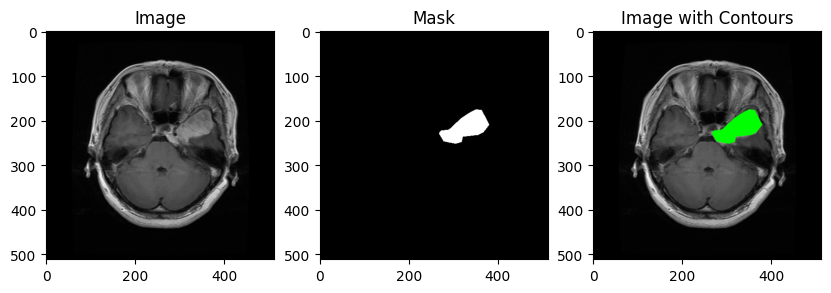

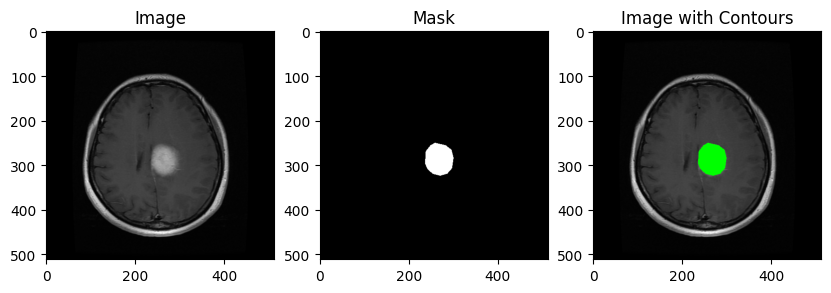

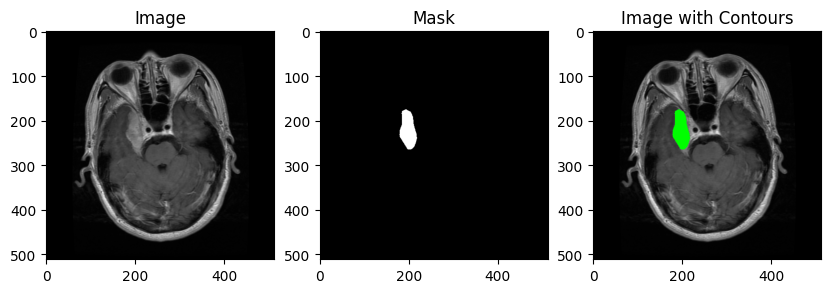

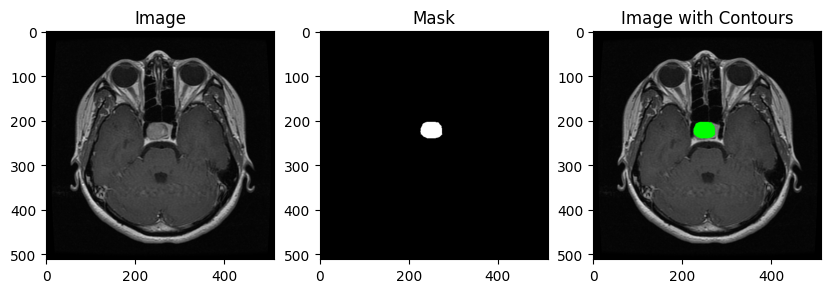

In [75]:
display_images_masks(image_dir,mask_dir)

In [76]:
import tqdm as tqdm
images_size=[]
masks_size=[]

for image, mask in tqdm.tqdm(zip(images, masks)):


    imagepath_full = os.path.join(image_dir, image)
    maskpath_full = os.path.join(mask_dir, mask)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)


3064it [00:14, 217.74it/s]


In [77]:
print(f"{list(set(images_size))}\n")
print(f"{list(set(masks_size))}\n")

[(512, 512, 3), (256, 256, 3)]

[(512, 512, 3), (256, 256, 3)]



In [78]:
for i in range(len(images)):
    images[i] = image_dir+'/'+images[i]
for i in range(len(masks)):
    masks[i] = mask_dir+'/'+masks[i]

print(images[0]+'\n'+masks[0])

/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1/images/1.png
/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1/masks/1.png


In [79]:
import tensorflow as tf

def load_image_and_mask(image_path, mask_path, img_size=(256, 256)):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image to [0, 1]

    # Load and preprocess the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)  # Load as grayscale
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32)  # Optionally normalize (e.g., divide by 255)

    return image, mask

In [80]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, masks))

# Map the dataset to load and preprocess the images and masks
dataset = dataset.map(lambda img, mask: load_image_and_mask(img, mask), num_parallel_calls=tf.data.AUTOTUNE)

# Batch, shuffle, and prefetch
batch_size = 32
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

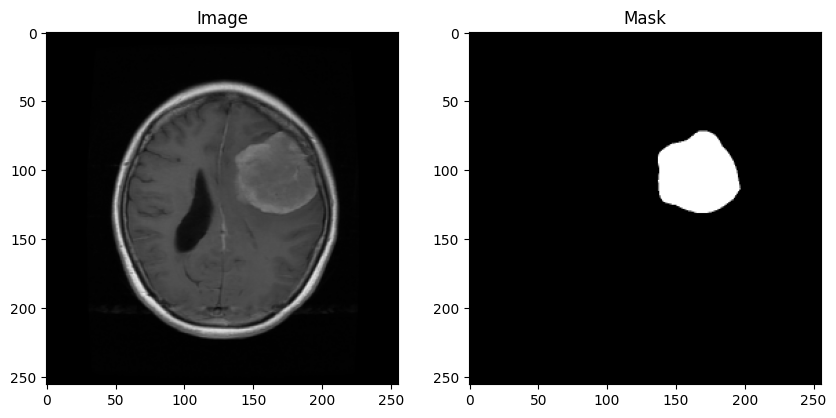

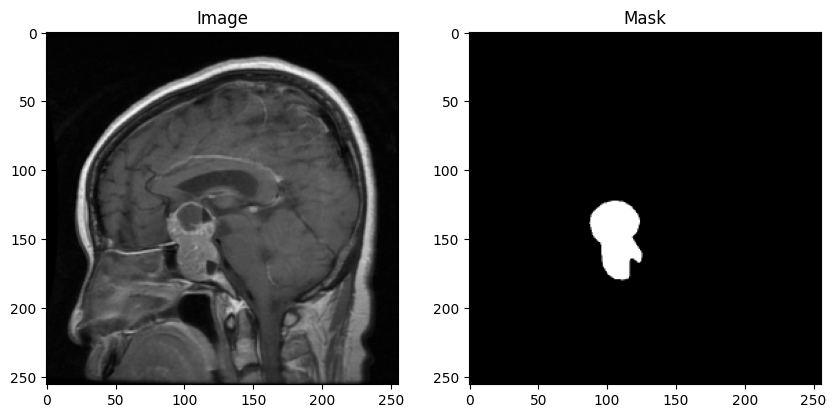

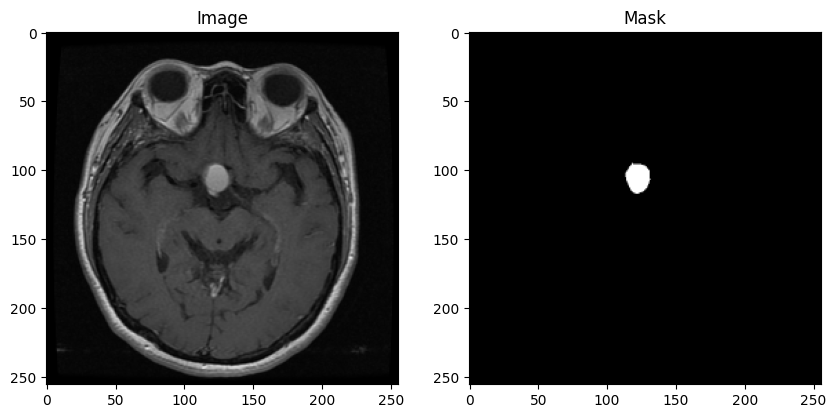

In [81]:
import matplotlib.pyplot as plt

for images, masks in dataset.take(1):  # Take one batch
    for i in range(3):  # Show a few examples
        plt.figure(figsize=(10, 5))

        # Display image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title("Image")

        # Display mask
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i, :, :, 0], cmap='gray')  # Assuming single-channel mask
        plt.title("Mask")

        plt.show()

In [82]:
print(images[0].shape)
print(masks[0].shape)

(256, 256, 3)
(256, 256, 1)


In [83]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np  # Import numpy if not already imported

# Convert TensorFlow tensors to NumPy arrays
images_np = np.array(images)
masks_np = np.array(masks)

train_image, test_image, train_mask, test_mask = train_test_split(
    images_np, masks_np, test_size=0.2, random_state=42
)

Unet.jpg

In [84]:
def encoder_block(inputs, num_filters):
  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(inputs)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)
  output = x
  x = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides=2)(x)

  return x, output

In [85]:
def decoder_block(inputs, skip_features, num_filters):
  x = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2,padding="same")(inputs)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  skip_features = tf.keras.layers.Lambda(lambda t: tf.image.resize(t,
                                                                    size = (x.shape[1],x.shape[2])))(skip_features)
  x = tf.keras.layers.Concatenate()([x, skip_features])

  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(x)
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [110]:
def U_NET(input_shape=(572,572,3),num_classes=1):
  inputs = tf.keras.layers.Input(input_shape)

  s1, output1 = encoder_block(inputs,64)
  s2, output2 = encoder_block(s1, 128)
  s3, output3 = encoder_block(s2, 256)
  s4, output4 = encoder_block(s3, 512)

  b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(s4)
  b1 = tf.keras.layers.Activation('relu')(b1)
  b1 = tf.keras.layers.Conv2D(1024, 3, padding="same")(b1)
  b1 = b1 = tf.keras.layers.Activation('relu')(b1)

  d1 = decoder_block(b1, output4, 512)
  d2 = decoder_block(d1, output3, 256)
  d3 = decoder_block(d2, output2, 128)
  d4 = decoder_block(d3, output1, 64)

  outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

  model = tf.keras.models.Model(inputs, outputs, name="U-Net")
  return model

In [93]:
print(train_mask.shape)

(25, 256, 256, 1)


In [111]:
model = U_NET(input_shape=(256, 256, 3), num_classes=1)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 256, 256, 64)   │          1,792 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_128   │ (None, 256, 256, 64)   │            256 │ conv2d_152[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_144            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ activation_144[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_129   │ (None, 256, 256, 64)   │            256 │ conv2d_153[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_145            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 128, 128, 64)   │              0 │ activation_145[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_154 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_130   │ (None, 128, 128, 128)  │            512 │ conv2d_154[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_146            │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_155 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ activation_146[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_131   │ (None, 128, 128, 128)  │            512 │ conv2d_155[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_147            │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33     

 Total params: 31,050,945 (118.45 MB)

 Trainable params: 31,041,345 (118.41 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [126]:
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0),
    loss='mean_squared_error',
    metrics=['accuracy']
)

In [113]:
import numpy as np
assert not np.isnan(train_image).any(), "Input contains NaN"
assert not np.isnan(train_mask).any(), "Labels contain NaN"

In [127]:
history = model.fit(train_image,train_mask,batch_size =16,epochs = 100, verbose='auto')

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 15s/step - accuracy: 0.8368 - loss: 631.7751
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 597ms/step - accuracy: 0.7669 - loss: 638.2659
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - accuracy: 0.7690 - loss: 614.5652
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - accuracy: 0.6746 - loss: 631.3125
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - accuracy: 0.6551 - loss: 625.4284
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 585ms/step - accuracy: 0.6348 - loss: 626.3477
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.6058 - loss: 659.3880
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - accuracy: 0.6004 - loss: 594.9655
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.5986 - loss: 619.8366
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 593ms/step - accuracy: 0.6033 - loss: 619.1324
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step - accuracy: 0.6009 - loss: 629.1598
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [123]:
print(train_image.shape)
print(train_image[3].shape)
y_pred =tf.round(model.predict(train_image[0].reshape(1, 256, 256, 3)))

(25, 256, 256, 3)
(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [124]:
print(y_pred)
print(train_mask[0].reshape(1, 256, 256, 1))

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]], shape=(1, 256, 256, 1), dtype=float32)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]


In [120]:
mask_pred = model.predict(test_image)
mask_pred = tf.round(mask_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [121]:
print(mask_pred.shape)
print(test_mask.shape)

(7, 256, 256, 1)
(7, 256, 256, 1)


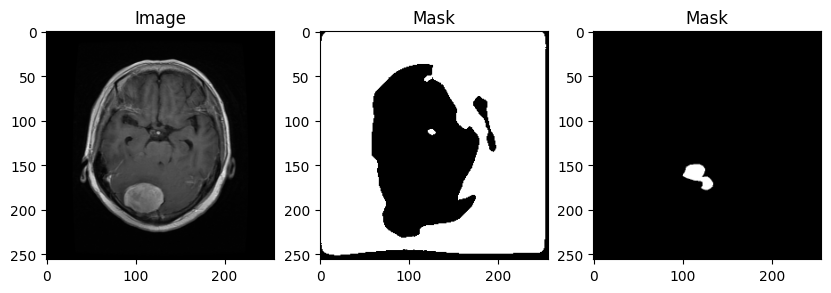

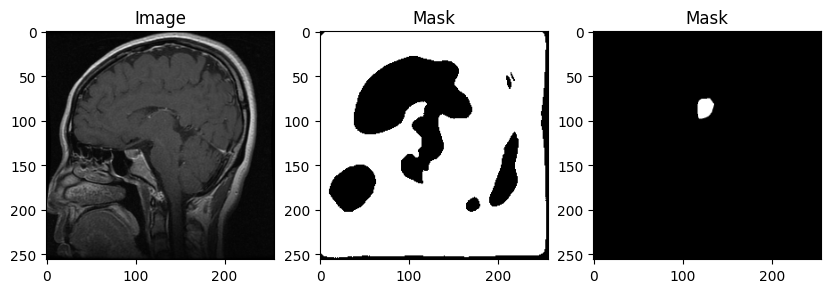

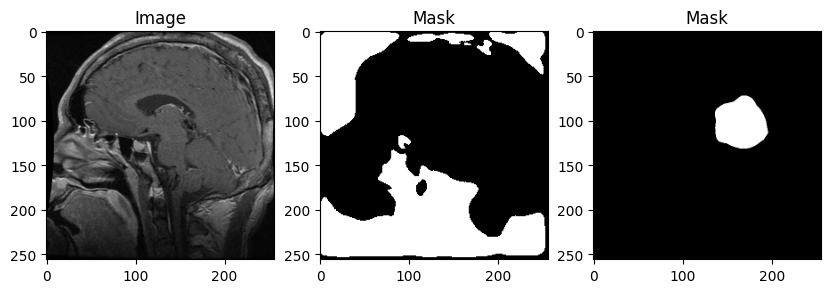

In [125]:
for i in range(3):  # Show a few examples
    plt.figure(figsize=(10, 5))

    # Display image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image[i])
    plt.title("Image")

    # Display mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred[i, :, :, 0], cmap='gray')  # Assuming single-channel mask
    plt.title("Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(train_mask[i, :, :, 0], cmap='gray')  # Assuming single-channel mask
    plt.title("Mask")

    plt.show()